# 음악 흥행 예측 모델

## 1.데이터 수집
### 1-1 가온데이터 수집

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import json
import pandas as pd
import os
import re
import time
import requests
from bs4 import BeautifulSoup
import json
import numpy as np

In [10]:
# 가온 디지털차트의 주간 날짜 딕셔너리 만들기
url = 'https://circlechart.kr/page_chart/onoff.circle?nationGbn=T&serviceGbn=ALL&'
# 주차별 날짜 리스트 뽑기
res = requests.get(url)
soup = BeautifulSoup(res.text, 'html.parser')
results = soup.select_one('body > div > main.hidden.md\:block > div > div > aside.mt-14.text-\[12px\] > section > div.float-right > label > select')
week_date_list = results.text.split('\n')

date_dict = {}
for i in range(2,len(week_date_list)-1):
    week_key = soup.select_one('body > div > main.hidden.md\:block > div > div > aside.mt-14.text-\[12px\] > section > div.float-right > label > select > option:nth-child({0})'.format(i))
    week_key = week_key.attrs['value']
    date_dict[week_key] = week_date_list[i]

# json 파일로 저장
with open('date_dict.json', 'w') as f : 
	json.dump(date_dict, f)
        

# 가온 디지털차트의 주간 날짜 딕셔너리 json 데이터 읽어오기
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

# 셀레니움을 위한 크롬 드라이버 설정
chrome_path = r"C:\Users\chromedriver.exe"
driver = webdriver.Chrome(chrome_path)


#필요한 폴더 없으면 생성
crawler_DIR = os.listdir('.')
   
if 'data' not in crawler_DIR:
    #폴더생성
    os.makedirs('./data')

 os.makedirs('./data/melon_data')
    
for year in range(2013,2024):

    for week_num in range(1,54):

        week_num = str(week_num).zfill(2)
        date_key = str(year) + str(week_num)

        url = f'https://circlechart.kr/page_chart/onoff.circle?nationGbn=T&serviceGbn=ALL&targetTime={week_num}&hitYear={year}&termGbn=week&yearTime=3'
        driver.get(url)


        elements = driver.find_elements(By.CSS_SELECTOR, '#pc_chart_tbody tr')
        result = []
        for idx, element in enumerate(elements):

            start_date, end_date = date_dict[date_key].split('~')
            rank = element.find_element(By.CSS_SELECTOR, 'td > div > span').text
            music = element.find_element(By.CSS_SELECTOR, 'td:nth-child(3) > div > section:nth-child(2) > div > div.font-bold.mb-2').text
            singer, album = element.find_element(By.CSS_SELECTOR, 'td:nth-child(3) > div > section:nth-child(2) > div > div.text-sm.text-gray-400.font-bold').text.split(' | ')
            # production = element.find_element(By.CSS_SELECTOR, 'td.text-left.text-xs > div:nth-child(1) > span').text
            # distribution = element.find_element(By.CSS_SELECTOR, 'td.text-left.text-xs > div.mt-2 > span').text

            temp = {
                'year':year,
                'week_num':week_num,
                'start_date':start_date,
                'end_date':end_date,
                'rank':rank,
                'music':music,
                'singer':singer,
                'album':album,
                # 'production':production,
                # 'distribution':distribution
            }
            
            result.append(temp)

        df = pd.DataFrame(result)
        df.to_csv(f'./data/gaon_data_{year}{week_num}.csv')

gaon_data_list = os.listdir('./data/')
list_tmp_df = []
for data in gaon_data_list:

    df = pd.read_csv(f'./data/{data}', index_col=0)
    df = df[:100]

    try:
        # 글자 행 삭제
        drop_index = df.loc[df['year']=='year'].index
        df = df.drop(drop_index, axis=0)
    except:
        pass
    list_tmp_df.append(df)
    
gaon_df = pd.concat(list_tmp_df, ignore_index=True)
gaon_df = gaon_df[['year', 'week_num', 'start_date', 'end_date', 'rank', 'music', 'singer', 'album']]

gaon_df.to_csv('./data/gaon_final_data.csv')

### 1-2 멜론 데이터 수집

In [ ]:
melon_final_result = []
for year in range(2013,2024):
    df = pd.read_csv('./data/gaon_final_data.csv', index_col=0)
    df = df.loc[df['year']==year]

    # 노래제목 리스트
    music_list = df['music'].unique().tolist()
    music_list = music_list[500:]

    # singer
    for music in music_list:
        try:
            singer = df['singer'].loc[df['music']==music].tolist()[0]
        except:
            print('오류', music)


    # 노래 id 딕셔너리 만들기 (key:노래id값, value:노래 제목)
    id_dict={}
    for music in music_list:
        singer = df['singer'].loc[df['music']==music].tolist()[0]

        # 가수이름 - 정규표현식으로 괄호 안의 내용 모두 삭제
        if singer.find('(') != -1:
            singer = re.sub('\([^)]*\)','', singer) 
        else:
            pass

        # 노래제목 - 정규표현식으로 괄호 안의 내용 모두 삭제
        if music.find('(') != -1:
            music = re.sub('\([^)]*\)','', music) 
        else:
            pass
        
        singer = singer.rstrip()
        music = music.rstrip()

        # 공백을 '+'로 바꿔줌
        music = music.replace(' ', '+')
        singer = singer.replace(' ', '+')

        # 특수문자 제거
        singer = re.sub('[-=+#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', "",singer)

        print(f'music:{music}, singer:{singer}')

        try:
            URL = f'https://www.melon.com/search/total/index.htm?q={music}+{singer}'
            header = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"}
            response = requests.get(URL,headers=header)
            time.sleep(1)
            soup = BeautifulSoup(response.text, 'html.parser')

            # try:
            links = soup.select_one('#frm_songList > div > table > tbody > tr:nth-child(1) > td:nth-child(1) > div > input')
            #frm_songList > div > table > tbody > tr:nth-child(1) > td:nth-child(1) > div > input

            music_id = links.attrs['value']
            print(music_id)
        except:
            print(f'오류, music:{music}')
            pass

        # +을 공백로 바꿔줌
        music = music.replace('+', ' ')
        singer = singer.replace('+', ' ')

        id_dict[music_id] = [music, singer]
        time.sleep(1)

    # 노래 id만 있는 리스트 
    id_list = list(id_dict.keys())



    # 데이터 뽑아오기
    result = []

    for id in id_list:
        music = id_dict[id][0]
        singer = id_dict[id][1]
        print(f'현재 {music} 크롤링 중')

        try:
            URL_1 = f'https://www.melon.com/song/detail.htm?songId={id}'
            response_1 = requests.get(URL_1,headers=header)
            time.sleep(1)
            soup = BeautifulSoup(response_1.text, 'html.parser')

            # 발매일, 장르
            release_date = soup.select_one('#downloadfrm > div > div > div.entry > div.meta > dl > dd:nth-child(4)').text
            category = soup.select_one('#downloadfrm > div > div > div.entry > div.meta > dl > dd:nth-child(6)').text
            

            # 좋아요 개수 json 접근
            URL_2 = f'https://www.melon.com/commonlike/getSongLike.json?contsIds={id}'
            response_2 = requests.get(URL_2,headers=header).text
            time.sleep(1)
            like_json = json.loads(response_2)
            music_like = like_json['contsLike'][0]['SUMMCNT']

            # 코멘트 개수 json 접근
            URL_3 = f'https://www.melon.com/song/songReviewCnt.json?songId={id}'
            response_3 = requests.get(URL_3,headers=header).text
            time.sleep(1)

            comment_json = json.loads(response_3)
            comment_count = comment_json['reviewValidCmtCnt']

            temp = {
            'music':music,
            'singer':singer,
            'music_id':id,
            'release_date':release_date,
            'category':category,
            'music_like':music_like,
            'comment_count':comment_count,
        }

            result.append(temp)
        except:
            print(f'오류, music:{music}')
            pass


    df = pd.DataFrame(result)
    df.to_csv(f'./data/melon_data/melon_data_{year}.csv')
    
melon_data_list = os.listdir('./data/melon_data')

list_tmp_df_m = []
for data in melon_data_list:
    df = pd.read_csv(f'./data/melon_data/{data}')

    # 글자 행 삭제 후 week_num값을 int로 형변환
    drop_index = df.loc[df['music']=='music'].index
    df = df.drop(drop_index, axis=0)

    list_tmp_df_m.append(df)

melon_df = pd.concat(list_tmp_df_m, ignore_index=True)
melon_df = melon_df[['music','singer','music_id','release_date','category','music_like','comment_count']]

## 2.데이터 전처리

In [2]:
# 저장한 데이터 불러오기
import pandas as pd
gaon_df = pd.read_csv('../data/gaon_final_data.csv', index_col=0)
melon_df = pd.read_csv('../data/melon_final_data.csv', index_col=0)

### 2-0 데이터 타입 변환

In [3]:
gaon_df['start_date'] = pd.to_datetime(gaon_df['start_date'], format='%Y.%m.%d')
gaon_df['end_date'] = pd.to_datetime(gaon_df['end_date'], format='%Y.%m.%d')
melon_df['release_date'] = pd.to_datetime(melon_df['release_date'], format='%Y.%m.%d')

### 2-1 데이터 특수문자 공백제거

In [4]:
gaon_df['music'] = gaon_df['music'].str.lower()
gaon_df['singer'] = gaon_df['singer'].str.lower()

In [8]:
import numpy as np
import re

def Save_Bracket(df, column):
    '''데이터의 괄호 안의 내용을 컬럼으로 추가하는 함수입니다.'''
    result = []
    new_column = []
    for i in range(len(df)):
        data = df.iloc[i][f'{column}']

        # 소문자로 바꾸기
        data = data.lower()

        # 괄호 안 내용 저장
        if data.find('(') != -1:
            p = re.compile('\(([^)]+)')
            data_bracket = p.findall(data)[0]
            # 괄호 삭제
            data = re.sub('\([^)]*\)','', data)
            # 양 쪽 공백 제거
            data = data.strip()

            # 리스트에 데이터 추가
            result.append(data)
            new_column.append(data_bracket)
            
        else:
            result.append(data)
            new_column.append(np.NaN)

    df[f'{column}'] = result
    df[f'{column} bracket'] = new_column

    return df


def Make_Clean_Name(df, column):
    '''음악 데이터를 정제하는 함수입니다'''
    result = []
    for i in range(len(df)):
        data = df.iloc[i][f'{column}']

        # 특수문자 제거 (콤마는 빼고 제거)
        data = re.sub('[-=+#/\?:^.@★*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', " ",data)

        # 소문자로 바꾸기
        data = data.lower()
        
        if column == 'singer':
            # 가수이름은 모든 공백 제거
            data = data.replace(' ','')
        else:  
            # 앞,뒤 공백 제거
            data = data.strip()

        result.append(data)

    df[f'{column}'] = result

    return df


# gaon_df 전처리
gaon_df = Save_Bracket(gaon_df, 'music')
gaon_df = Save_Bracket(gaon_df, 'singer')
gaon_df = Make_Clean_Name(gaon_df, 'music')
gaon_df = Make_Clean_Name(gaon_df, 'singer')

# melon_df 전처리
melon_df = Make_Clean_Name(melon_df, 'music')
melon_df = Make_Clean_Name(melon_df, 'singer')

### 2-2 차트에 든 횟수 DV(종속변수) 컬럼 만들기

In [9]:
gaon_df['singer-music'] = gaon_df['singer'] + '-' + gaon_df['music']
DV_df = pd.DataFrame(gaon_df['singer-music'].value_counts())
DV_df.reset_index(drop=False, inplace=True)
DV_df.rename(columns={'index':'singer-music', 'singer-music':'rank_count'}, inplace=True)

### 2-3 멜론데이터에 가온차트 start_date 데이터 컬럼으로 추가

In [10]:
def Add_startdate(df1, df2):
    date_list = []
    for i in range(len(df1)):

        music = df1['music'].iloc[i]
        singer = df1['singer'].iloc[i]

        try:
            start_date = df2['start_date'].loc[(df2['music']==music) & ((df2['singer']==singer)|(df2['singer bracket']==singer))].iloc[0]
            date_list.append(start_date)
        except:
            date_list.append(np.NaN)

    df1['start_date'] = date_list

    return df1



In [11]:
melon_df = Add_startdate(melon_df, gaon_df)

### 2-4 발매 7일이내 순위 진입 컬럼 추가

In [ ]:
# 날짜 datetime 형식으로 변환환
melon_df['start_date'] = pd.to_datetime(melon_df['start_date'])
melon_df['release_date'] = pd.to_datetime(melon_df['release_date'])


In [ ]:

# 7일 계산해서 calculate컬럼으로 추가
melon_df['calculate'] = melon_df['release_date'] - melon_df['start_date']
# 7일이내면 값 1, 아니면 0
melon_df['within 7days'] =  abs(melon_df['calculate']) < pd.Timedelta(days=7).replace({True:1, False:0})
# melon_df['within 7days'].replace({True:1, False:0}, inplace=True)

# 쓸모없는 컬럼 삭제
melon_df.drop(columns=['start_date', 'calculate'], inplace=True)

### 2-5 카테고리의 국내드라마 데이터로 OST컬럼 생성

In [ ]:
# ost컬럼 추가 + 카테고리에서 발라드,국내드라마에서 국내드라마는 삭제
def Make_OST_column(df):
    ost_list = []
    category_list = []

    for i in range(len(df)):
        category = df['category'].iloc[i]
        try:
            a, b = category.split(', ')
            if b == '국내드라마':
                ost_list.append(1)
                category_list.append(a)
            else:
                ost_list.append(0)
                category_list.append(category)
        except:
            ost_list.append(0)
            category_list.append(category)

    df['ost'] = ost_list
    df['category'] = category_list

    return df

melon_df = Make_OST_column(melon_df)

In [ ]:

# 고유값인 가수-노래제목 컬럼 만들기
melon_df['singer-music'] = melon_df['singer']+'-'+melon_df['music']

# 가수-노래제목 기준으로 중복 제거
melon_df.drop_duplicates(subset='singer-music', inplace=True)

# 인덱스 재정렬
melon_df.reset_index(drop=True, inplace=True)

### 2-6 종속변수 생성 - 가온 차트인 횟수

In [ ]:
# 가수 괄호 딕셔너리 만들기
singer_bracket_dict = {}
bracket_df = gaon_df[gaon_df['singer bracket'].notnull()]
bracket_df = bracket_df[['singer', 'singer bracket']]
bracket_dict = bracket_df.set_index('singer').T.to_dict('records')
bracket_dict = bracket_dict[0]

# 종속변수 붙이기

def Make_DV(df1, df2, dict):
    
    count_list = []
    for i in range(len(df1)):

        # 멜론 데이터에 있는 노래가 DV_1에 있는 지 확인 후, rank_count 데이터 붙이기
        singer_music = df1['singer-music'].iloc[i]
        singer = df1['singer'].iloc[i]
        music = df1['music'].iloc[i]

        try:
            # 괄호 안의 이름으로도 찾아보기
            singer_bracket = dict[singer]
            global singer_singerbracket
            singer_singerbracket = singer_bracket+'-'+music
            

            # DV_df에 해당 노래가 있으면, rank_count값을 리스트에 추가
            if len(df2.loc[(df2['singer-music']==singer_music)|(df2['singer-music']==singer_singerbracket)]) > 0:
                rank_count = df2['rank_count'].loc[(df2['singer-music']==singer_music)|(df2['singer-music']==singer_singerbracket)].iloc[0]
                count_list.append(rank_count)
            else:
                count_list.append(np.NaN)
        except:
            # DV_df에 해당 노래가 있으면, rank_count값을 리스트에 추가
            if len(df2.loc[(df2['singer-music']==singer_music)]) > 0:
                rank_count = df2['rank_count'].loc[df2['singer-music']==singer_music].iloc[0]
                count_list.append(rank_count)
            else:
                count_list.append(np.NaN)

    df1['rank_count'] = count_list

    return df1

music_df = Make_DV(melon_df, DV_df, bracket_dict)

# 필요없는 컬럼 singer-music 삭제
music_df.drop(columns=['singer-music'], inplace=True, axis=0)

In [ ]:
music_df.columns

## 3.EDA

In [12]:
#Library for modelling
from sklearn.preprocessing import LabelEncoder #Encodes Categorical Data into Numerical
from sklearn.model_selection import train_test_split #For spliting data into training and testing sets
from sklearn.linear_model import LinearRegression #Linear Regression model
from sklearn.linear_model import Lasso #Lasso regression model
from sklearn.linear_model import Ridge #Ridge Regression Model
from sklearn.ensemble import RandomForestRegressor#Random Forest Regression Model
from sklearn.metrics import mean_absolute_error 

#Libraries for Deep Learning
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

#Library for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "./NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

<Axes: title={'center': 'Top 10 music_like category'}, xlabel='category', ylabel='music_like'>

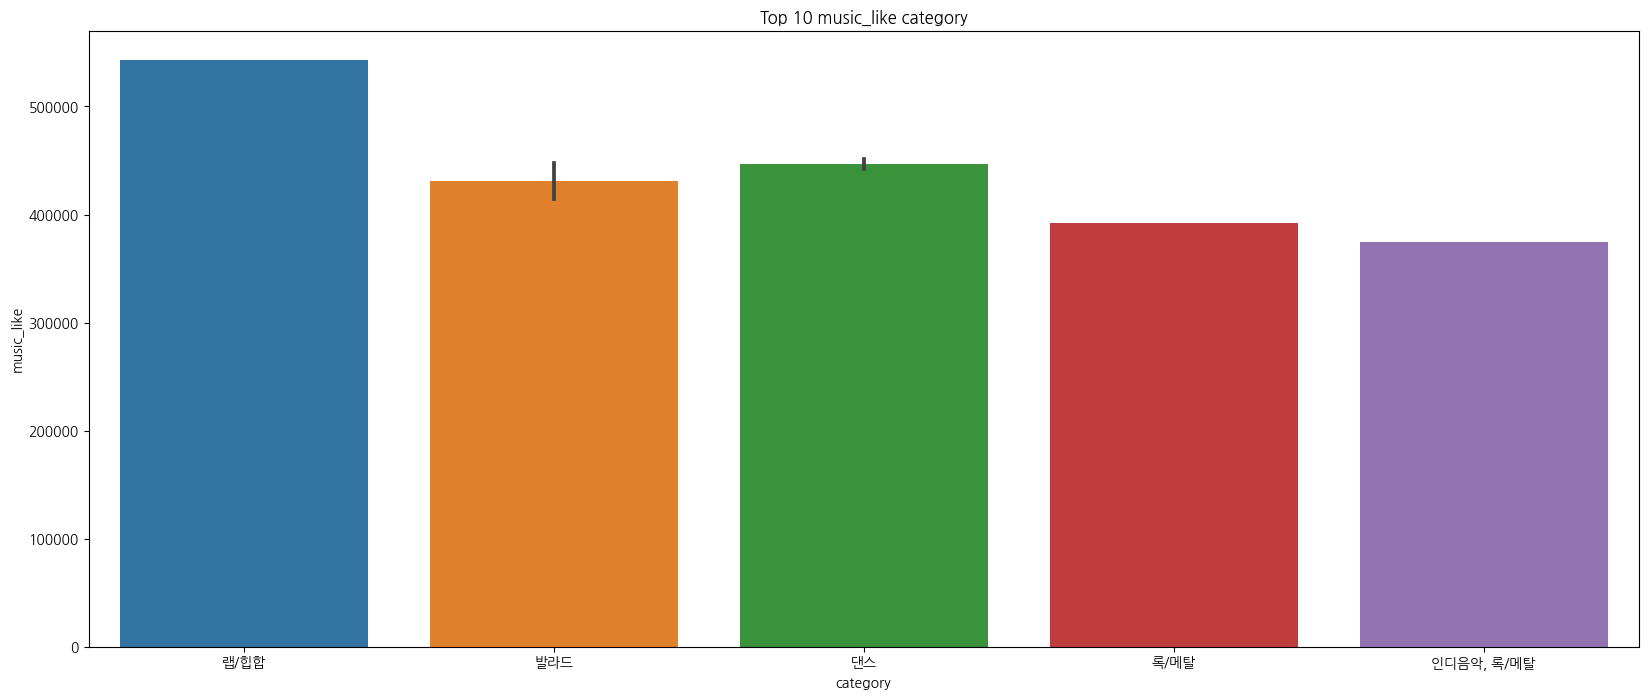

In [13]:
#Sorting by music_like
sort_streams=music_df.sort_values(by=['music_like'],ascending=False)

plt.figure(figsize=(20,8))
plt.title("Top 10 music_like category")
sns.barplot(x='category',y='music_like',data=sort_streams.head(10))

<Axes: title={'center': 'Top 10 Most Liked Artists'}, xlabel='singer', ylabel='music_like'>

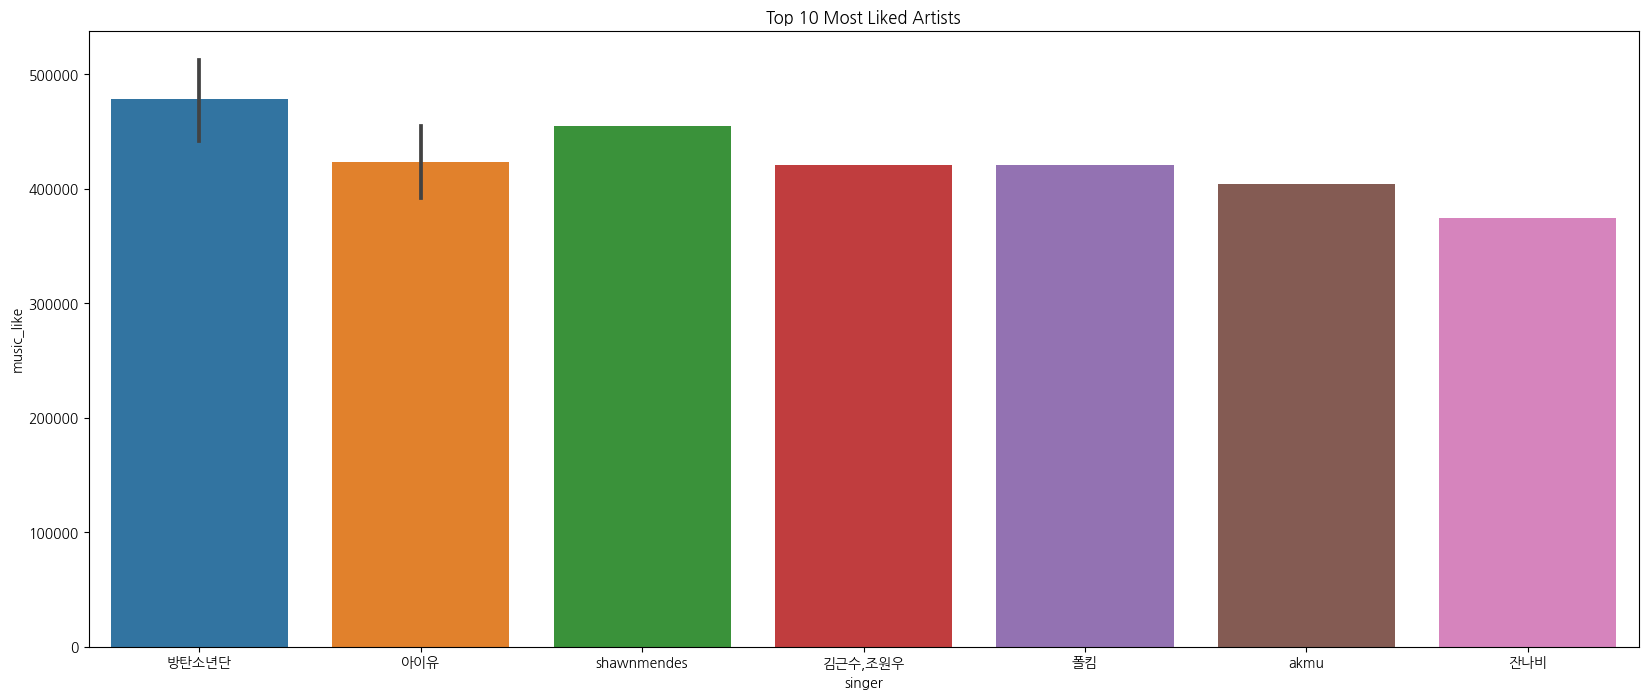

In [14]:
plt.figure(figsize=(20,8))
plt.title("Top 10 Most Liked Artists")
sns.barplot(x='singer',y='music_like',data=sort_streams.head(10))

C:\Users\bin\AppData\Local\Temp\ipykernel_36560\1449779839.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=music_df.corr()


<Axes: >

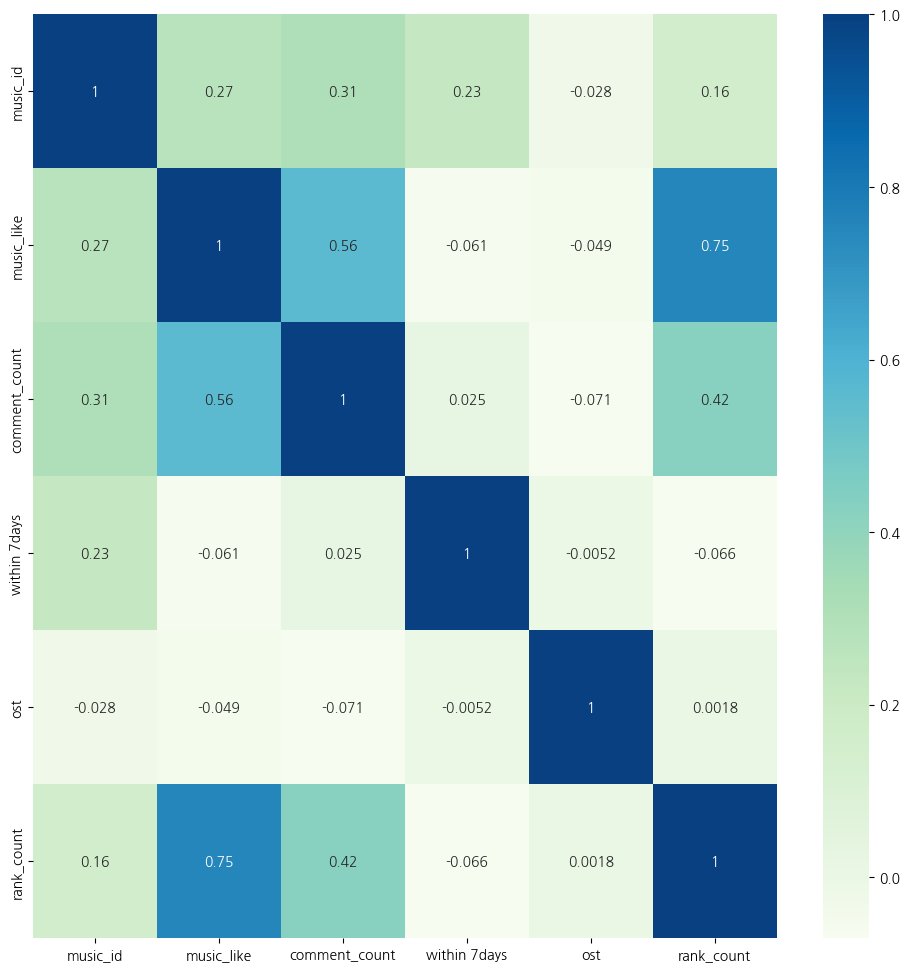

In [16]:
#Calculating Correlation
corr=music_df.corr()

#Plotting Correlation
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,cmap="GnBu")

## 4.모델링
### 4-1 데이터 전처리 - word2vec

In [17]:
from gensim.models.word2vec import Word2Vec

m_singer_list = music_df['singer'].tolist()

#모델 불러오기
#리스트인 melon_singer를 word2vec , mincount 1로 1개이상 값은 다 

# model = Word2Vec(sentences=[m_singer_list], min_count=1)
model = Word2Vec(sentences=[m_singer_list], min_count=1, vector_size=1)

singer_w2_dict = {}
for singer in m_singer_list:
    singer_w2_dict[singer] = model.wv[singer]



# singer값을 word2vec 데이터로 바꾸기
def make_word2vec_column(df,column,dict):
    w2_list = []
    for i in range(len(df)):

        singer = df[f'{column}'].iloc[i]
        try:
            data = dict[singer][0]
            w2_list.append(data)
        except:
            w2_list.append(np.NaN)

    df[f'{column}'] = w2_list

    return df

music_df = make_word2vec_column(music_df,'singer',singer_w2_dict)

### 4-2 데이터 전처리 - 카테고리 변수 원핫인코딩

In [18]:
# 카테고리 맨 앞꺼 빼고 삭제하는 함수
def delete_category(df):
    cate = []

    for i in range(len(df)):
        category = df['category'].iloc[i]
        category_list = category.split(',')
        cate.append(category_list[0])

    df['category'] = cate

    return df
music_df = delete_category(music_df)


from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
# fit_transform은 train에만 사용하고 test에는 학습된 인코더에 fit만 해야한다

train_cat = ohe.fit_transform(music_df[['category']])
music_df = pd.concat([music_df.drop(columns=['category']),
           pd.DataFrame(train_cat, columns=['category_' + col for col in ohe.categories_[0]])], axis=1)


# 사용 안할 컬럼 삭제
music_df.drop(columns=['music','release_date'], axis=0, inplace=True)

c:\Users\bin\anaconda3\envs\shinhanAI\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 4-3 모델링

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_log_error as msle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def get_scores(model, xtrain, xtest, ytrain, ytest):
  pred1 = model.predict(xtrain)
  pred2 = model.predict(xtest)

  A1 = r2_score(ytrain, pred1)
  A2 = r2_score(ytest, pred2)

  # mlse는 음수 안됨
  pred2 = np.where(pred2<0, 0, pred2)
  B = msle(ytest, pred2)
  C = np.sqrt(B) #rmsle

  data = [round(x, 4) for x in [A1, A2, C]]
  names = 'r2_train r2_test rmsle'.split()

  temp = pd.Series(data, index=names)
  return temp


def make_models(xtrain, xtest, ytrain, ytest):
  temp = pd.DataFrame()

  model1 = LinearRegression().fit(xtrain, ytrain)
  temp['model1'] = get_scores(model1, xtrain, xtest, ytrain, ytest)

  model2 = DecisionTreeRegressor(random_state=0).fit(xtrain, ytrain)
  temp['model2'] = get_scores(model2, xtrain, xtest, ytrain, ytest)
  for d in range(3,9):
    model2 = DecisionTreeRegressor(max_depth = d, random_state=0).fit(xtrain, ytrain)
    temp[f'model2_{d}'] = get_scores(model2, xtrain, xtest, ytrain, ytest)

  model3 = RandomForestRegressor(random_state=0).fit(xtrain, ytrain)
  temp['model3'] = get_scores(model3, xtrain, xtest, ytrain, ytest)
  for d in range(3,9):
    model3 = RandomForestRegressor(max_depth = d, random_state=0).fit(xtrain, ytrain)
    temp[f'model3_{d}'] = get_scores(model3, xtrain, xtest, ytrain, ytest)

  model4 = XGBRegressor(objective='reg:squarederror').fit(xtrain, ytrain)
  temp['model4'] = get_scores(model4, xtrain, xtest, ytrain, ytest)

  temp = temp.T
  return temp


# 데이터 분리
# XF, YF 분리 후에
YF = music_df['rank']
XF = music_df.drop(columns='rank', axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.2, random_state=0)

In [20]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(music_df, test_size=0.2, random_state=25)

testing_data_rank=testing_data['rank_count']
testing_data=testing_data.drop('rank_count', axis=1)

x_train=training_data.drop('rank_count',axis=1)
y_train=training_data['rank_count']


#Random Forest Regression
r_model=RandomForestRegressor(n_estimators=50)
r_model.fit(x_train,y_train)
print(r_model.score(x_train,y_train))

#Making predictions on test set 
r_predict=r_model.predict(testing_data)

r_output=pd.DataFrame({'Id':testing_data.index,'Predicted Streams':r_predict,'Actual Stream':testing_data_rank})
print(r_output)

0.9450273028860358
        Id  Predicted Streams  Actual Stream
1729  1729               8.16             11
3640  3640               1.86              1
3218  3218              13.14              1
3000  3000              55.38            268
3912  3912               7.26              1
...    ...                ...            ...
4141  4141               3.56              7
295    295               1.82              1
1129  1129               1.86              2
1988  1988               1.18              1
455    455               9.04             11

[877 rows x 3 columns]
